**A PYTHON IMPLEMENTATION TO REMOVE ARTIFACTS IN CENTRELINES OF BLOOD VESSELS IN BIOLOGICAL IMAGES**

My PhD is aimed at analysing the architecture of the pituitary gland vasculature and how it may be altered by a physiological challenge. So far in my PhD I have obtained 3D images of the pituitary vasculature and the next step is to analyse the images. I have managed to label vessels in each image (segmentation) and obtain their centrelines (skeletonisation), as shown below:

Text(0.5, 1.0, 'Skeletonisation')

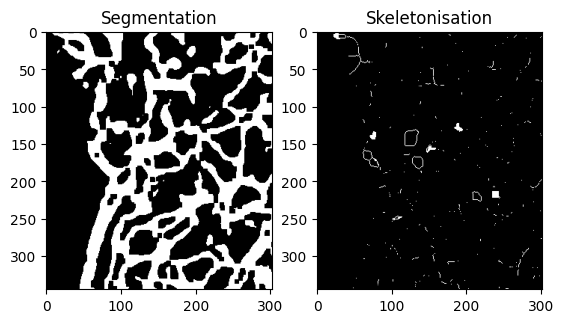

In [1]:
#Import packages
from skimage.io import imread
import matplotlib.pyplot as plt
#Import images of segmented and skeletonised vasculature
seg = imread("../processed_images/vasc_skel_problem_seg.tif")
skel = imread("../processed_images/vasc_skel_problem.tif")
#Plot
fig, ax = plt.subplots(1,2)
ax[0].imshow(seg[32], cmap="gray")
ax[0].set_title("Segmentation")
ax[1].imshow(skel[32], cmap="gray")
ax[1].set_title("Skeletonisation")

However, the skeleton contains strange artifacts - loops and blobs (note that the skeleton looks incomplete/fragmented, this is because it was derived in 3D but only displayed in 2D). The typical way that biologists would deal with these artifacts is to manually have to go through each image and remove the artifacts by hand. This is impractical for me since I have so many images to analyse so I decided to try and use some of the python skills I have learned in the course to create a script that would automatically recognise the artifacts and remove them. An image is essentially just a very large matrix of numbers (pixel values) so it can be manipulated just like any matrix.

So I have 2 types of artifacts to deal with:

1. Filled blobs - these are always artifacts.
2. Loops - these are artifacts only if they don't actually surround a hole in the segmentation.

Let's start by trying to deal with the first type of artifact.

In [2]:
#Import all required packages
from skimage.morphology import skeletonize, binary_dilation
from skimage.segmentation import flood_fill
from skimage.measure import find_contours
import numpy as np
import cv2
from tifffile import imwrite
import pandas as pd
from collections import Counter

**1. Remove filled blobs**

Approach: find 2D skeleton per slice for the 3D skeleton. This will take the blob and find a one-pixel wide line through it, replacing the blob with the true centreline instead.

In [3]:
# Convert skeleton to boolean as required by skeletonize function
skel = skel.astype("bool")
# Make a copy to store the 2D skeleton
skel_2d = skel.copy()
# For each z slice
for z1 in range(skel.shape[0]):
    img = skel[z1, :, :]
    # Skeletonize in 2D
    img_skel = skeletonize(img)
    # And put into the 2D skeleton array
    skel_2d[z1, :, :] = img_skel

Test if it worked:

Text(0.5, 1.0, 'Skeleton with blobs removed')

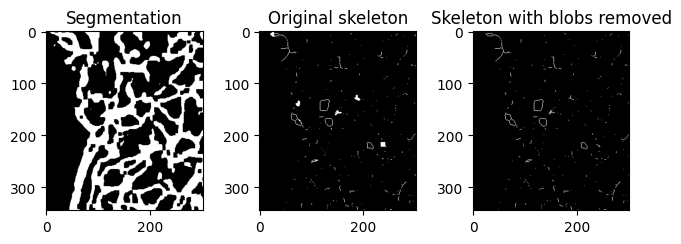

In [4]:
fig, ax = plt.subplots(1,3, constrained_layout=True)
ax[0].imshow(seg[32], cmap="gray")
ax[0].set_title("Segmentation")
ax[1].imshow(skel[32], cmap="gray")
ax[1].set_title("Original skeleton")
ax[2].imshow(skel_2d[32], cmap="gray")
ax[2].set_title("Skeleton with blobs removed")

Success! All filled blobs have been removed and replaced by their centrelines.

**2. Remove loops that don't surround a hole**

*Step 1*: identify the regions within the loops using flood fill to separate out the background that is not within loops

In [5]:
# Convert 2D skeleton from boolean into integers for flood fill
skel_2d = skel_2d.astype("uint8")
# Create a new array to hold the flood filled data
skel_filled = skel_2d.copy()
# For each z slice
for z2 in range(skel_2d.shape[0]):
    img = skel_2d[z2, :, :]
    # Apply a flood fill from the right lower corner giving the flooded areas a value of 2
    # Note: we need to set connectivity=0 to respect the "corners" of the skeleton loops
    img_filled = flood_fill(img, (320, 300), 2, connectivity=0)
    # Feed the flood filled image into the new array
    skel_filled[z2, :, :] = img_filled

Text(0.5, 1.0, 'Skeleton with loop insides labelled')

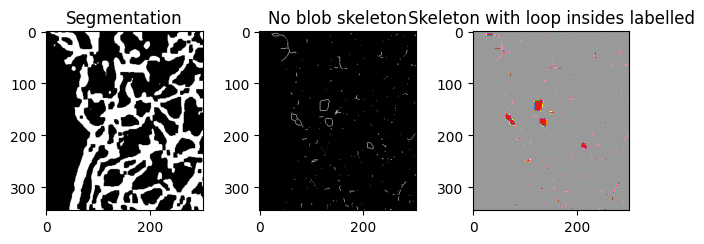

In [6]:
fig, ax = plt.subplots(1,3, constrained_layout = True)
ax[0].imshow(seg[32], cmap="gray")
ax[0].set_title("Segmentation")
ax[1].imshow(skel_2d[32], cmap="gray")
ax[1].set_title("No blob skeleton")
ax[2].imshow(skel_filled[32], cmap="Set1")
ax[2].set_title("Skeleton with loop insides labelled")

Result: skeleton pixels have value of 1 (plotted as pink), insides of the loop are 0 (inherited background, plotted as red) and non-loop background is 2 (plotted as grey).

*Step 2*: pick out each individual filled loop ("instance segmentation")

In [7]:
# First modify array so that filled loops are 1 and everything else is 0 for segmentation
skel_filled_blobs = skel_filled.copy()
skel_filled_blobs[skel_filled_blobs == 0] = 3
skel_filled_blobs[skel_filled_blobs == 1] = 0
skel_filled_blobs[skel_filled_blobs == 2] = 0
skel_filled_blobs[skel_filled_blobs == 3] = 1

Find contours of each blob and fill the contours on the inside

In [8]:
# Create empty array to hold blobs
filled_blobs_instance_plots_all = []
# For each z slice
for z3 in range(skel_filled_blobs.shape[0]):
    img = skel_filled_blobs[z3, :, :]
    # Find the contours of the blobs
    # Note: level=0.5 to separate 1 (blob) from 0 (background)
    contours = find_contours(img, level=0.5) 
    # Annoying: convert contours to opencv contours
    all_contours = []
    for con in contours:
        cv_contour = []
        for point in con:
            # opencv has coordinates in the opposite order...
            intify = [int(point[1]), int(point[0])]
            cv_contour.append([intify])
        all_contours.append(cv_contour) 
    # Convert to numpy format
    all_contours_np = []
    for con in all_contours:
        np_cont = np.array(con)
        all_contours_np.append(np_cont)
    # Fill contours and create separate plots for each separated blob    
    filled_blobs_instance_plots = []
    for c in all_contours_np:
        # Create blank image of same size as each z slice to act as "canvas"
        blank = np.zeros((345, 302), np.uint8)
        # Fill in the contours (-1 as last argument)
        filled_contours = cv2.drawContours(blank, [c.astype(int)], -1, (255), -1)
        filled_blobs_instance_plots.append(filled_contours)
    filled_blobs_instance_plots_all.append(filled_blobs_instance_plots)

Plot filled loops to check if the method worked:

Text(0.5, 1.0, 'Filled loop 6')

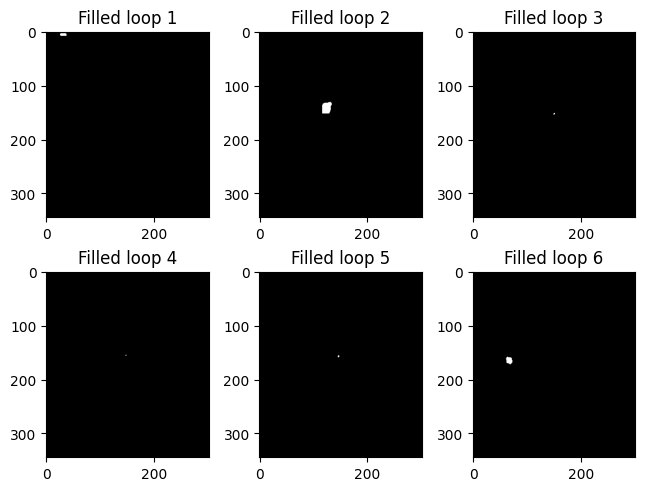

In [9]:
fig, ax = plt.subplots(2,3, constrained_layout = True)
ax[0,0].imshow(filled_blobs_instance_plots_all[32][0], cmap="gray")
ax[0,0].set_title("Filled loop 1")
ax[0,1].imshow(filled_blobs_instance_plots_all[32][1], cmap="gray")
ax[0,1].set_title("Filled loop 2")
ax[0,2].imshow(filled_blobs_instance_plots_all[32][2], cmap="gray")
ax[0,2].set_title("Filled loop 3")
ax[1,0].imshow(filled_blobs_instance_plots_all[32][3], cmap="gray")
ax[1,0].set_title("Filled loop 4")
ax[1,1].imshow(filled_blobs_instance_plots_all[32][4], cmap="gray")
ax[1,1].set_title("Filled loop 5")
ax[1,2].imshow(filled_blobs_instance_plots_all[32][5], cmap="gray")
ax[1,2].set_title("Filled loop 6")

Success! the filled_blobs_instance_plots_all list now contains for each z slice a list with plots for each blob per slice.

*Step 3*: remove a blob's dilated contours i.e. the loop in the skeleton if the blob contains a hole in the vessel segmentation.

In [10]:
# Separate segmentation into z slices like the blob plots
seg_2d_plots = []
for z4 in range(seg.shape[0]):
    img = seg[z4, :, :]
    # Change values so that 0 is vessel and 255 is hole/background for ease of finding non-zero values in both images in the next step
    img[img == 0] = 6
    img[img == 255] = 7
    img[img == 6] = 255
    img[img == 7] = 0
    seg_2d_plots.append(img)

In [11]:
#Copy each z slice of vessel segmentation as many times as there were blobs per slice to get same shape
seg_2d_plots_new = seg_2d_plots.copy()
for i in range(len(filled_blobs_instance_plots_all)):
    blobplot_i = filled_blobs_instance_plots_all[i]
    if len(blobplot_i) >0:
        seg_2d_i = seg_2d_plots[i]
        seg_2d_i_rep = []
        seg_2d_i_rep.extend([seg_2d_i] * len(blobplot_i))
        seg_2d_plots_new[i] = seg_2d_i_rep

Find out what blobs contain a hole in the vessel segmentation and if not then dilate the blob (this to allow it to cover region of the original skeleton)

In [12]:
# Make placeholder list of same shape that indicates if a blob contains a hole 
blob_with_hole_truefalse = seg_2d_plots_new.copy()
# Make new list for dilated blobs
blobs_dilated_ifnecessary = filled_blobs_instance_plots_all.copy()
# Array to add if we have a hole in the blob
truematrix = np.array([5,5,5])
# Array to add if there is not a hole in the blob
falsematrix = np.array([0,0,0])
# Define footprint for blob dilation
dil_footprint = np.ones((3,3))

In [13]:
for j in range(len(blobs_dilated_ifnecessary)):
    # For each slice get corresponding blobs and vessel segmentation
    blobplot_j = blobs_dilated_ifnecessary[j]
    seg_2d_j = seg_2d_plots_new[j]
    # If there are blobs in the slice
    if len(blobplot_j) >0:
        # Then iterate through each blob plot
        for nplot in range(len(blobplot_j)):
            # Find out if the blob contains a hole in the vessel segmentation
            res = np.logical_and(blobplot_j[nplot], seg_2d_j[nplot]).any()
            # If there is a hole
            if res == True:
                # Add the true array
                blob_with_hole_truefalse[j][nplot] = truematrix
            else:
                # Get the blob plot and dilate the blob
                plot = blobplot_j[nplot]
                dil_blobplot = binary_dilation(plot, dil_footprint)
                dil_blobplot = dil_blobplot.astype("uint8")
                # Replace with the dilated blob plot
                blobs_dilated_ifnecessary[j][nplot] = dil_blobplot
                # And add false array
                blob_with_hole_truefalse[j][nplot] = falsematrix

Result: we now have blob_with_hole_truefalse which tells us the "index" of each blob which should be removed because it does not contain a hole and blobs_dilated_ifnecessary with all blobs and those that don't have a hole in the segmentation have been dilated

*Final step*: if a plot in blobs_dilated_ifnecessary has a [0,0,0] in the corresponding index of blob_with_hole_truefalse we should remove the overlapping skeleton region

In [14]:
# Create an array for the updated skeleton
newskel = skel_2d.copy()

for k in range(len(blobs_dilated_ifnecessary)):
    # If we have blobs in the slice
    plotlist = blobs_dilated_ifnecessary[k]
    if len(plotlist) > 0:
        # Then iterate through the blob plots
        for blobplot_n in range(len(plotlist)):
            # If we have [0,0,0] in the index of the blob i.e. blob does not contain a hole
            if np.array_equal(blob_with_hole_truefalse[k][blobplot_n], [0,0,0]):
                # Remove the pixels from the original skeleton
                newskel[k][plotlist[blobplot_n] == 1] = 0

Text(0.5, 1.0, 'Skeleton with artifacts removed')

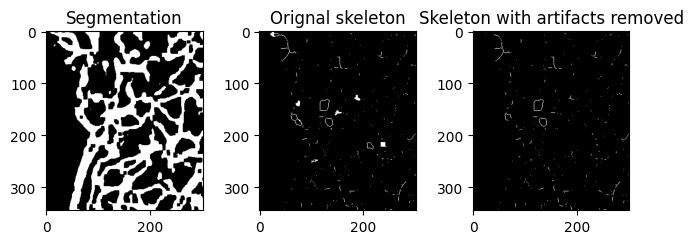

In [15]:
fig, ax = plt.subplots(1,3, constrained_layout = True)
ax[0].imshow(seg[32], cmap="gray_r")
ax[0].set_title("Segmentation")
ax[1].imshow(skel[32], cmap="gray")
ax[1].set_title("Orignal skeleton")
ax[2].imshow(newskel[32], cmap="gray")
ax[2].set_title("Skeleton with artifacts removed")

Result: we have successfully removed all artifacts (blobs + loops that don't surround a hole in the skeleton)!

In [16]:
# Save the result :)
imwrite("../processed_images/vasc_skel_problem_noloops.tif", newskel)

**Plot summaries of artifact removal**

It would be useful to know how many blobs and loops were removed and how their numbers were distributed across the image stack so let's plot a couple of summaries at the end.

How many blobs were removed in total? How many loops?

In [17]:
#First count number of blobs removed across slices
all_blobs = []
# For each z slice
for skel_slice in range(skel.shape[0]):
    img_skel = skel[skel_slice, :, :]
    # Find the contours of the blobs
    # Note: level=0.5 to separate 1 (blob) from 0 (background)
    contours_skel = find_contours(img_skel, level=0.5) 
    # Annoying: convert contours to opencv contours
    all_contours_skel = []
    for con_skel in contours_skel:
        cv_contour_skel = []
        for point_skel in con_skel:
            # opencv has coordinates in the opposite order...
            intify_skel = [int(point[1]), int(point[0])]
            cv_contour_skel.append([intify_skel])
        all_contours_skel.append(cv_contour_skel) 
    # Convert to numpy format
    all_contours_np_skel = []
    for con_skel in all_contours_skel:
        np_cont_skel = np.array(con_skel)
        all_contours_np_skel.append(np_cont_skel)
    # Fill contours and create separate plots for each separated blob    
    skel_plots = []
    for c_skel in all_contours_np_skel:
        # Create blank image of same size as each z slice to act as "canvas"
        blank_skel = np.zeros((345, 302), np.uint8)
        # Fill in the contours (-1 as last argument)
        filled_contours_skel = cv2.drawContours(blank_skel, [c_skel.astype(int)], -1, (255), -1)
        skel_plots.append(filled_contours_skel)
    all_blobs.append(skel_plots)

#Count total number of blobs removed
n_blobs_per_slice = []
for z5 in all_blobs:
    image_blob = z5
    n_blobs_per_slice.append(len(image_blob))

#Count total number of loops removed
removed_loop_n = []
for each in range(len(blob_with_hole_truefalse)):
    each_list = blob_with_hole_truefalse[each]
    if len(each_list) > 0:
        # Then iterate through the blob plots
        for each_n in range(len(each_list)):
            if np.array_equal(blob_with_hole_truefalse[each][each_n], [0,0,0]):
                removed_loop_n.append(1)

print(sum(n_blobs_per_slice), "blobs were removed in total")
print(sum(removed_loop_n), "loops were removed in total")

22014 blobs were removed in total
388 loops were removed in total


Next, let's plot the distribution of both types of artifacts across the image stack.

In [18]:
#Count number of loops removed per slice
removed_loop_slice_n = []
for each in range(len(blob_with_hole_truefalse)):
    each_list = blob_with_hole_truefalse[each]
    if len(each_list) > 0:
        # Then iterate through the blob plots
        for each_n in range(len(each_list)):
            if np.array_equal(blob_with_hole_truefalse[each][each_n], [0,0,0]):
                removed_loop_slice_n.append(each)

#Get the counts for each slice
removed_loop_counts = Counter(removed_loop_slice_n)
loop_dist = pd.DataFrame.from_dict(removed_loop_counts, orient='index').reset_index()

#Fill in zero counts for slices that don't have any loops
loop_dist.index = loop_dist['index']
loop_dist = loop_dist.reindex(np.arange(0, 95 + 1)).fillna(0)
loop_dist.drop(loop_dist.columns[[0]], axis=1, inplace=True)
loop_data = pd.Series(loop_dist.iloc[:,0])
loop_data = loop_data.rename('Loops')

#Create a joint DataFrame
blob_data = pd.Series(n_blobs_per_slice)
artif_data = pd.concat([blob_data, loop_data], axis=1)
artif_data = artif_data.rename({0: 'Blobs'}, axis=1)

<AxesSubplot:>

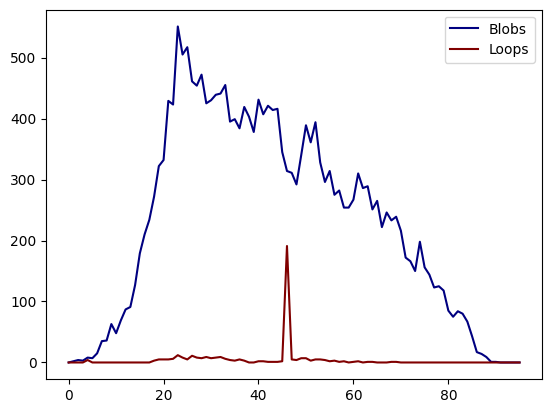

In [19]:
artif_data.plot(colormap='jet')

Both types of artifacts were low in number at the start and end of the image stack which makes sense due to the spherical shape of the pituitary. The highest number of blobs were found around slice 20 and there was an extreme peak in loop artifacts around slice 45.

Finally, let's count how many true loops (not artifacts) remain in the image as they are true structures but may interfere with path finding through the skeleton.

In [20]:
#Count total number of loops
n_loops_per_slice = []
for z6 in filled_blobs_instance_plots_all:
    image_loop = z6
    n_loops_per_slice.append(len(image_loop))

n_remain_loops = sum(n_loops_per_slice)-sum(removed_loop_n)  
    
print(n_remain_loops, "loops remain in the image")

148 loops remain in the image


**CONCLUSION**

Using skills learned from the course and additional learning, I was able to make use of common python libraries (mainly numpy) to solve a specific problem I was facing in my research. I can now make use of this script to remove artifacts from my all my images and save considerable time in the process.